## Inicializacao

In [34]:
import numpy as np
import pandas as pd
import sympy as sp
import scipy.io as sc 
import scipy.signal as signal
from sympy import symbols, pprint
import matplotlib.pyplot as plt
from structureSelector import *
from methods.utils.utilities import *
import plotly.express as px

def metrics(y, yest):
    residuo1 = y - yest
    mape = round(np.mean(np.abs(residuo1 / (yest + np.finfo(np.float64).eps))), 5)
    print('RMSE:', np.sqrt(np.mean(np.square(residuo1))), 'MSE:', np.mean(np.square(residuo1)), '\nAET:', np.sum(np.abs(residuo1)), '\nMAPE:', str(mape) + '%')
    cc = np.corrcoef(y, yest)
    #print("Correlation pearson:", np.mean(cc))

def recursiveMQ(y, phi, pad):
    size = phi.shape[1]
    nit = y.shape[0]
    p = 1000 * np.eye(size)
    teta = np.zeros((size, 1))

    erro = np.zeros(nit)
    print(phi.shape, nit)

    for t in range(0, nit):
        fi = phi[t,:]
        fi = fi.reshape(-1, 1)
        #print(teta, fi.T,'\n')
        erro[t] = y[t] - np.dot(teta.T, fi)
        k = np.dot(np.dot(p, fi), 1 / (1 + np.dot(np.dot(fi.T, p), fi)))
        teta = teta + np.dot(k, erro[t])
        p = p - np.dot(np.dot(k, fi.T), p)

    return np.squeeze(teta)

def integrate(p, ts=0.1):
    r = np.zeros(p.shape)
    r[0] = p[0] * ts
    for i in range(1, p.shape[0]):
        r[i] = r[i-1] + p[i] * ts
    return r

ballbeam  = np.loadtxt('data/ballbeam.dat')
print(ballbeam.shape)
part = 500#ballbeam.shape[0] // 2#700

u = ballbeam[:part, 0].reshape((1,-1))
y = ballbeam[:part, 1].reshape((1,-1))

wn = 0.1
b1, a1 = signal.butter(4, wn, 'low')

filtered = signal.filtfilt(b1, a1, y, padlen=100)

dy = np.zeros(filtered.shape)
dy[:, 1:] = (filtered[0, 1:] - filtered[0, :-1]) / 0.1

t = np.arange(0, part/10, 0.1)

fig=px.line(x=t, y=y[0].T, height=400, width=1300)
fig.add_scatter(x=t, y=filtered[0].T ,mode='lines')
fig.show()

wn = 0.2
b1, a1 = signal.butter(4, wn, 'low')
ufiltered = signal.filtfilt(b1, a1, u, padlen=100)
#ufiltered[0, :15] = 0
U = integrate(ufiltered.T).T

fig=px.line(x=t, y=u[0].T, height=400, width=1300)
fig.add_scatter(x=t, y=ufiltered[0].T, mode='lines')
fig.add_scatter(x=t, y=U[0].T, mode='lines')
fig.show()


(1000, 2)


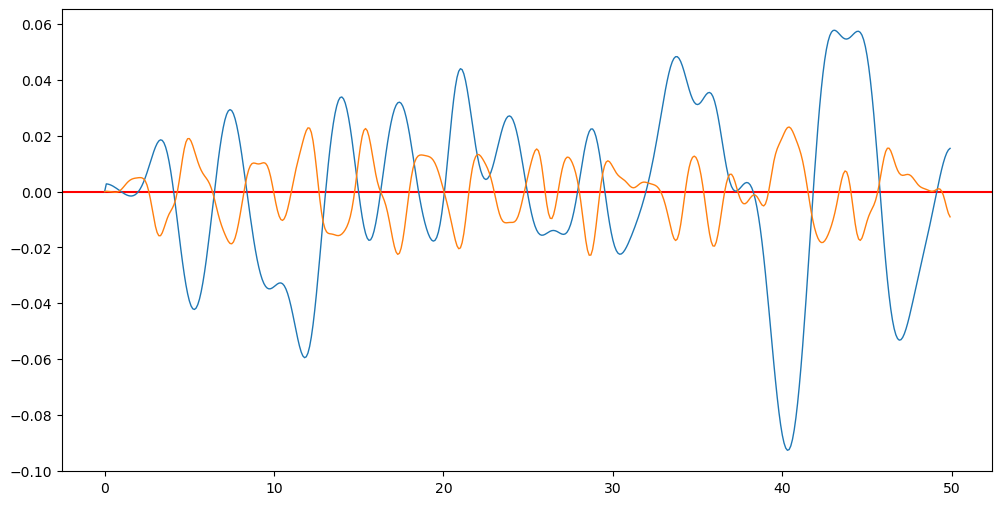

In [35]:
d2y = np.zeros(filtered.shape)
d2y[:, 1:] = (dy[0, 1:] - dy[0, :-1]) / 0.1
d3y = np.zeros(filtered.shape)
d3y[:, 1:] = (d2y[0, 1:] - d2y[0, :-1]) / 0.1
du = np.zeros(filtered.shape)
du[:, 1:] = (ufiltered[0, 1:] - ufiltered[0, :-1]) / 0.1

'''
plt.figure(figsize=(12, 6))
plt.plot(t, y[0].T, linewidth=1.0)
plt.plot(t, u.T, linewidth=1.0)
plt.savefig('figure/BallBeam.png')
plt.show()
'''
plt.figure(figsize=(12, 6))
plt.axhline(y=0, color='r')
plt.plot(t, dy[0].T, linewidth=1.0)
plt.plot(t, du.T, linewidth=1.0)
plt.show()

### Estimação

16 (16, 490)
(490, 7) 490
[Y1.1 d(Y1.1) U1.10 U1.1 d(U1.1) U1.3 U1.4]
-8.20774323904573*U1.1 + 0.191231656396013*U1.10 + 12.7883807660522*U1.3 - 4.47951901668504*U1.4 + 0.936517541975692*Y1.1 + 1.29750930048848*d(U1.1) + 0.100158480391946*d(Y1.1)
Simulação livre
--------s:  [Y1.1, d(Y1.1), I(Y1.1), U1.0, U1.1, U1.2, U1.3, U1.4, U1.5, U1.6, U1.7, U1.8, U1.9, U1.10, d(U1.1), I(U1.1)]



Simulação livre
RMSE: 0.04127461512385573 MSE: 0.0017035938536224204 
AET: 14.38978203510688 
MAPE: 2.56497%

Um passo a frente
RMSE: 0.0007914416005820699 MSE: 6.263798071319086e-07 
AET: 0.282649927170036 
MAPE: 0.12242%


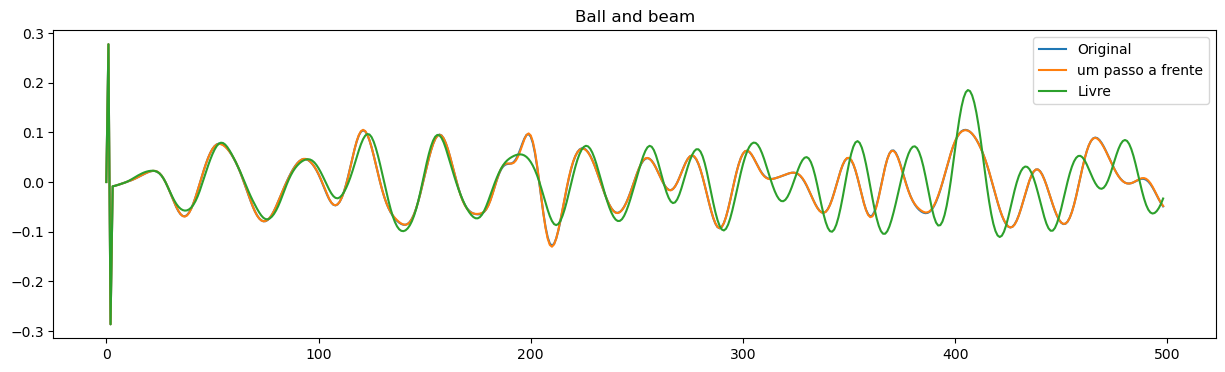

In [57]:
#Selecione o tanque 
iy = d3y
iu = du
output = 0  # 0 ou 1
num = [8]
params = []
params.append({'nb':[1],'na':[10], 'level':1, 'nonlinear':[0,0,0,0,0], 'root':False, 'delay':0, 'diff':True})
#params.append({'nb':[1],'na':[20], 'level':3, 'nonlinear':[0,0,0,0,0], 'root':False, 'delay':5, 'diff':True})#10

sselector = structureSelector()
ss = sselector.symbolic_regressors(**params[output], intg=True)
#print(ss)

vCandidatos = sselector.matrix_candidate(iu, iy, **params[output], dt=0.1, intg=True)

print(len(ss), vCandidatos.shape)

pad = max(max(params[output]['nb']), max(params[output]['na']))
psi, selected  = sselector.semp(vCandidatos.T, iy[output, pad:], num[output], 0.000000001)

model = ss[selected]
#print(model, selected)

theta = LSM(iy[output, pad:], psi)
theta1 = recursiveMQ(iy[output, pad:], psi, pad)

model = ss[selected]
pprint(model)
print(model @ theta)


slivre = sselector.predict(iu, iy, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1, intg=True)
yhat = sselector.oneStepForward(iu, iy, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['diff'], dt=0.1, intg=True)


print("\nSimulação livre")
metrics(iy, slivre)
print("\nUm passo a frente")
metrics(iy, yhat)

plt.figure(figsize=(15,4))
fim = -1
s = 0#t-20
g = 105
plt.title("Ball and beam")

plt.plot(iy[output, s:fim].T, label='Original')
plt.plot(yhat[s:fim], label='um passo a frente')
plt.plot(slivre[s:fim], label='Livre')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


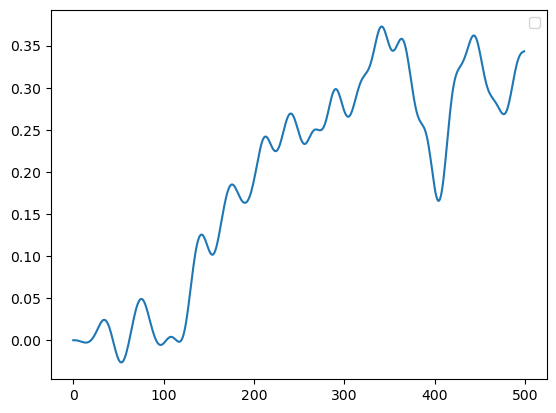

In [59]:
slivre[0:3] = 0
si = integrate(slivre)
ssi = integrate(si)
plt.plot(ssi)
plt.legend()
plt.show()


## Selecao de estrutura

(485, 4) 485
[Y1.1 Y1.2 U1.2 U1.4] 0.204668818876847*U1.2 - 0.199228259652741*U1.4 + 1.98200793390064*Y1.1 - 0.983584201074071*Y1.2
Simulação livre
--------s:  [Y1.1, Y1.2, U1.1, U1.2, U1.3, U1.4, U1.5, U1.6, U1.7, U1.8, U1.9, U1.10, U2.1, U2.2, U2.3, U2.4, U2.5, U2.6, U2.7, U2.8, U2.9, U2.10, U2.11, U2.12, U2.13, U2.14, U2.15]

Simulação livre
RMSE: 0.038727233173971566 MSE: 0.001499798589311164 
AET: 14.593880149408346 
MAPE: 2.36874%

Um passo a frente
RMSE: 0.00019168679017650782 MSE: 3.674382552817254e-08 
AET: 0.07164456188493776 
MAPE: 0.34711%


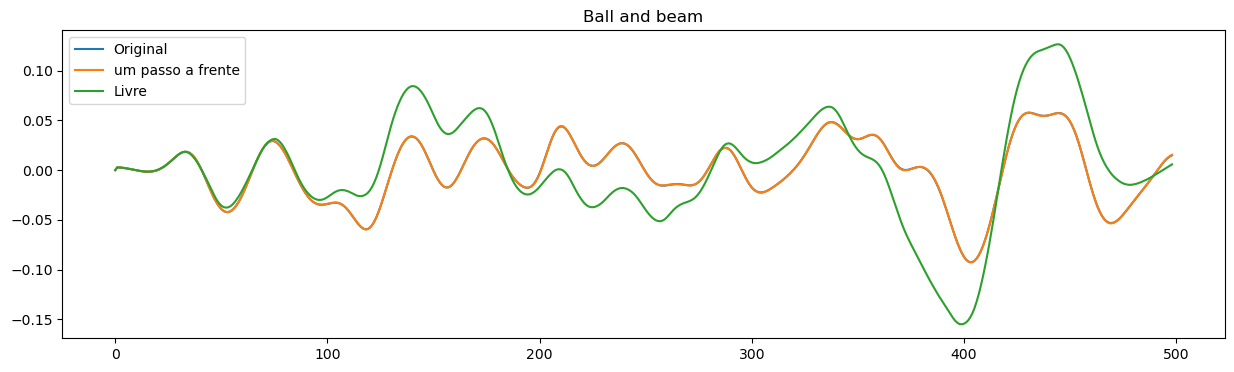

In [37]:
#Selecione o tanque 
output = 0  # 0 ou 1
# entrada composta
u2 = np.vstack((u, U))
Y = dy

num = [5]
params = []
#params.append({'nb':[2],'na':[10], 'level':3, 'nonlinear':[0,0,0,0,0], 'root':False, 'delay':1, 'diff':True})
#params.append({'nb':[2],'na':[15, 0], 'level':1, 'nonlinear':[0,0,0,0,0], 'root':False, 'delay':2, 'diff':False})#n3
#params.append({'nb':[2],'na':[6, 0], 'level':3, 'nonlinear':[1,1,0,0,0], 'root':False, 'delay':0, 'diff': False})#8
params.append({'nb':[2],'na':[10, 15], 'level':1, 'nonlinear':[0,0,0,0,0], 'root':False, 'delay':1, 'diff': False}) #best result 4

sselector = structureSelector()
ss = sselector.symbolic_regressors(**params[output])
#print(ss)

vCandidatos = sselector.matrix_candidate(u2, Y, **params[output], dt=0.1)

pad = max(max(params[output]['nb']), max(params[output]['na']))
psi, selected  = sselector.semp(vCandidatos.T, Y[output, pad:], num[output], 0.000000001)

model = ss[selected]
#print(model, selected)

theta = LSM(Y[output, pad:], psi)
theta1 = recursiveMQ(Y[output, pad:], psi, pad)

model = ss[selected]
print(model, model @ theta)


slivre = sselector.predict(u2, Y, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1)
yhat = sselector.oneStepForward(u2, Y, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['diff'], dt=0.1)


print("\nSimulação livre")
metrics(Y, slivre)
print("\nUm passo a frente")
metrics(Y, yhat)


t = -1
s = 0#t-20
g = 105
plt.figure(figsize=(15,4))
plt.title("Ball and beam")

plt.plot(Y[output, s:t].T, label='Original')
plt.plot(yhat[s:t], label='um passo a frente')
plt.plot(slivre[s:t], label='Livre')
plt.legend()
plt.show()

### Simulação

In [ ]:
uVal = ballbeam[0:part+200, 0].reshape((1,-1))
yVal = ballbeam[0:part+200, 1].reshape((1,-1))# / 0.15

UVal = np.zeros(uVal.shape)
#UVal[0, 0] = u[1, -1] + 0.1 * uVal[0, 0]
for i in range(1, uVal.shape[1]):
    UVal[0, i] = UVal[0, i-1] + uVal[0, i] * 0.075

#uVal = np.vstack((uVal, UVal)) 
    
yVal[0, 1:] = (yVal[0, 1:] - yVal[0, :-1])/0.1
yVal[:, :20] = 0
#print(u[1, -1], uVal[1, 0])
plt.plot(uVal.T)
plt.plot(yVal.T)
plt.show()

In [ ]:
#uVal = UVal
valLivre = sselector.predict(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1)
yhat = sselector.oneStepForward(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['diff'], dt=0.1)

print("Modelo selecionado:")
pprint( model @ theta)

f, ax = plt.subplots(1,2, figsize=[16,5])

ax[0].plot(yVal[output].T, label='Original')
ax[0].plot(valLivre, label='Livre')
#ax[0].plot(yhat, label='um passo a frente')
ax[0].set_title("Simulações")
ax[0].legend()


ax[1].plot(yVal[output].T - valLivre, label='Livre')
ax[1].plot(yVal[output].T - yhat, label='um passo a frente')
ax[1].set_title("Resíduos")
ax[1].legend()
plt.show()

In [ ]:
print(valLivre.shape)
pprint(model)
rr = integrate(valLivre)
rt = integrate(yhat)

plt.plot(rr)
plt.plot(rt)
plt.show()

## Teste